In [10]:
using LinearAlgebra
using Plots
using SparseArrays
using Arpack #Eigenvalues of sparse arrays with eigs()
using DifferentialEquations
# using DiffEqFlux
using Optim
using ForwardDiff
using DelimitedFiles
using LineSearches
using LaTeXStrings

In [3]:
#Def parameters
n_cutoff = 8
N = 2 * n_cutoff + 1
NHilbert = N^2
n = sparse(Diagonal(LinRange(-n_cutoff, n_cutoff, N))) #Perhaps implement using StaticArrays
Id = sparse(I, N, N)
exp_iPhi = spdiagm(-1 => ones(N - 1));

#Def Hamiltonian parameters
E_J_GHz = 10.0 #scale of E_J in units of h*GHz, h-bar = 1, h = 2pi
E_C = 1/100  #Charging energies
E_J = 1.0 #Josephson energies
phi_ext = 0.995pi

prefactor = 4 * E_C
Kinetic = 2pi * E_J_GHz * prefactor * (kron(n^2, Id) .+ kron(Id, n^2))

Potential1 = -2pi * E_J_GHz * kron(1 / 2 * (exp_iPhi .+ exp_iPhi'), Id) # -E_J1 cos(phi1)
Potential2 = -2pi * E_J_GHz * kron(Id, 1 / 2 * (exp_iPhi .+ exp_iPhi')) # -E_J2 cos(phi2)
Pot3Mat = kron(exp_iPhi, exp_iPhi')
Pot3Const = -2pi * E_J_GHz * E_J / 2

function get_Pot3(Φ_ext = phi_ext)
    M = exp(im * Φ_ext) * Pot3Mat
    return Pot3Const * (M + M')
end

function dPot3_dphi(Φ_ext = phi_ext)
    M = exp(im * Φ_ext) * Pot3Mat
    return (im * Pot3Const) .* (M - M')
end

Potential3 =  get_Pot3() #-E_J3 cos(phi1 - phi2 + phi_ext)
Potential12 = E_J * (Potential1 + Potential2)
KinPot12 = Kinetic + Potential12
chargecoupling = kron(n, Id);

In [120]:
# function limit_func(param,pmin,pmax)
#     if pmin <= param <= pmax
#         return param
#     elseif param < pmin
#         return pmin
#         # param = pmin
#     else
#         return pmax
#         # param = pmax
#     end
#     # return param
# end

function limit_func(param,pmin,pmax)
    (pmax - pmin) * (1/(1 + exp(-param))) + pmin
end

function inv_limit_func(param,pmin,pmax)
    # -log( (pmax - pmin  + 2e-8) / (param - pmin + 1e-8) - 1)
    -log( (pmax - pmin) / (param - pmin) - 1)
end

function alpha(p, t)
    Tₐ = limit_func(p[2],0,15)
    Tₚ = 30 - 2*Tₐ#p[3]
    αmin = limit_func(p[4],0.5,1)
    abs_slope = (1 - αmin)/Tₐ
    if t < Tₐ
        return 1 - abs_slope * t
    elseif t > Tₐ + Tₚ
        return αmin + abs_slope * (t - Tₐ - Tₚ)
    else
        return αmin
    end
end


# dalphadt(p, t) = ForwardDiff.derivative(t̃ -> alpha(p,t̃), t)
# dalphadp(p, t) = ForwardDiff.gradient(p̃ -> alpha(p̃,t), p)
# ddalphadpdt(p, t) = ForwardDiff.gradient(p̃ -> dalphadt(p̃,t), p)

function envelopes!(E, Edot, Tᵣ, Tₐ, Tₚ, t)
    if Tₐ < t < Tₐ + Tᵣ
        arg = pi / 2 * (t - Tₐ) / Tᵣ
        E *= sin(arg)^2
        Edot *= 2*sin(arg)*cos(arg)*pi/(2*Tᵣ)
    elseif Tₐ + Tᵣ <= t <= Tₐ + Tₚ - Tᵣ
        E *= 1
        Edot *= 0
    elseif Tₐ + Tₚ - Tᵣ < t < Tₐ + Tₚ
        arg = pi / 2 * (Tₐ + Tₚ - t) / Tᵣ
        E *= sin(arg)^2
        Edot *= 2*sin(arg)*cos(arg)*(-pi)/(2*Tᵣ)
    else
        E *= 0
        Edot *= 0
    end
    return (E, Edot)
end

function pulse(p, t)
    Tₐ = limit_func(p[2],0,15)
    Tₚ = 30 - 2*Tₐ#p[3]
    Tᵣ = limit_func(p[1],0,Tₚ/2)
    # αmin = p[4]
    ϕ = p[5]
    f = p[6]
    A = p[7]
    # Φ_ext = p[8]
    λ = p[9]

    amp = pi * A / (Tₚ - Tᵣ)
    E = amp
    Edot = copy(amp)
    E, Edot = envelopes!(E, Edot, Tᵣ, Tₐ, Tₚ, t)
    arg = f*(t - Tₐ) + ϕ
    return E*cos(arg) + Edot*λ*sin(arg)
end

# dpulsedt(p, t) = ForwardDiff.derivative(t̃ -> pulse(p, t̃), t)
# dpulsedp(p, t) = ForwardDiff.gradient(p̃ -> pulse(p̃, t), p)

pulse (generic function with 1 method)

In [5]:
#[Tᵣ, Tₐ, Tₚ, αmin, ϕ, f, A, Φ_ext, λ]
# p = [2, 10, 10, 0.7, 0.5418, 0.9763*2.482542369189332, 1.01556/0.2949509890806259, 0.995pi, 0.05289]
# p = [3.65, #14.84292607534555
# 11.341751839758764,
# 10.0,
# 0.501, #-649.7661732132904
#  0.5828557110984577,
# -7.161153490188593,
#  1.3640811715268795,
# -22.06506034791423,
# -4.957612200539009]
# p = [2, 10, 10, 0.51, 0.0, 1.5*2.482542369189332, 1.5/0.2949509890806259, 0.995pi, 0.0]
# p = [2, 10, 10, 0.7, 0.5418, 0.9763*2.482542369189332, 1.01556/0.2949509890806259, 0.995pi, 0.05289]

# p[1] = inv_limit_func(p[1],0,15 - p[2])
# p[2] = inv_limit_func(p[2],0,15)
# p[4] = inv_limit_func(p[4],0.5,1)

In [13]:
Es = eigvals(Matrix(KinPot12 + Potential3))
ψs = eigvecs(Matrix(KinPot12 + Potential3));

M = Pot3Const * exp(im * phi_ext) * Pot3Mat

# fu0 = ψs[:,1:2]

# N=30
# # Ua = ψs[:,1:N]'*Potential3*ψs[:,1:N]
# Um = ψs[:,1:N]'*(Pot3Const * exp(im * phi_ext) * Pot3Mat) * ψs[:,1:N]
# Uv = ψs[:,1:N]'*chargecoupling*ψs[:,1:N]
ψ0 = ψs[:,1:2]#zeros(N,2)
# ψ0[1,1] = 1.0
# ψ0[2,2] = 1.0

u0 = ψs[:,1:2]#cat(real(Es[1:N].-Es[1]),Um,Uv,ψ0,dims=2)

Hphimærke = dPot3_dphi(phi_ext)
Hphi = KinPot12 + Potential3
IdNH = diagm(ones(ComplexF64, NHilbert))
E1mærke = ψs[:,1]'* Hphimærke * ψs[:,1]
E2mærke = ψs[:,2]'* Hphimærke * ψs[:,2]
tmp1 = - (Hphi - (real(Es[1]) .* IdNH)) \ (Hphimærke - (E1mærke .* IdNH))
tmp2 = - (Hphi - (real(Es[2]) .* IdNH)) \ (Hphimærke - (E2mærke .* IdNH))

fu0 = cat(u0,-tmp1*ψs[:,1],-tmp2*ψs[:,2],dims=2)

# sizep = length(p)
;

In [38]:
function f!(du, u, p, t)
    x = u[:,1:2]
    # ψ = u[:,3:4]
    H = KinPot12 + alpha(p,t) .* Potential3 + pulse(p,t) .* chargecoupling

    du[:,1:2] = -im .* (H * x)
    # du[:,3:4] = -im .* (H * ψ) - alpha(p,t) .* ((M - M') * x)
end

Uv = chargecoupling
Ua = Potential3#Um + Um'
dUa = M - M'

function b!(du, u, p, t)
    x = u[:,1:2]
    ψ = u[:,3:4]
    λ = u[:,5:6]
    ϕ = u[:,7:8]
    ps = u[:,9]

    miH = -im .* (KinPot12 + alpha(p,t) .* Potential3 + pulse(p,t) .* chargecoupling)

    du[:,1:2] = miH * x
    du[:,3:4] = miH * ψ - alpha(p,t) * dUa * x
    du[:,5:6] = miH * λ
    du[:,7:8] = miH * ϕ + alpha(p,t) * dUa * λ
    
    du[1:sizep,9] = (
    - real(im * tr(λ' * Uv * x)) .* dpulsedp(p, t) 
    - real(im * tr(λ' * Ua * x)) .* dalphadp(p,t) )
    
    du[8,9] = real(tr(λ' * dUa * x) * alpha(p,t))
    
    du[sizep+1:2*sizep,9] = (
    - real(im * (tr(ϕ' * Uv * x) + tr(ψ' * Uv * λ))) .* dpulsedp(p,t) 
    - real(im * (tr(ϕ' * Ua * x) + tr(ψ' * Ua * λ))) .* dalphadp(p,t) 
    # + real(tr(ϕ' * (F .* Ua) * x) + tr(ψ' * (F .* Ua) * λ)) .* ddalphadpdt(p,t) 
    - real(tr(x' * dUa * λ)) .* dalphadp(p,t) )
    # - real(im * tr(x' * (F .* dUa)' * λ)) .* ddalphadpdt(p,t)
end

b! (generic function with 1 method)

In [113]:
m = 0.001/pi #pi*2e-6
l1s = []
l2s = []
params = []
calls = [1]

grad = zeros(sizep)
loss = [0.0]

function calc(p, last_p, grad, loss)
    if p != last_p
        copy!(last_p, p)
        forward_prob = ODEProblem(f!, fu0, (0.0, 30.0), p)
        sol_f = solve(forward_prob, p=p, save_everystep=false, reltol=1e-8, abstol=1e-8)

        # DT = sol_f.u[end][:,1]
        # UmT = sol_f.u[end][:,2:N+1] #Ua = Um + Um'
        # UvT = sol_f.u[end][:,N+2:2*N+1]
        xT = sol_f.u[end][:,1:2]
        ψT = sol_f.u[end][:,3:4]

        λ = cat(ψ0[:,2]*ψ0[:,2]'*xT[:,1],ψ0[:,1]*ψ0[:,1]'*xT[:,2],dims=2)
        ϕ = cat(-ψ0[:,2]*ψ0[:,2]'*ψT[:,1],-ψ0[:,1]*ψ0[:,1]'*ψT[:,2],dims=2)

        ps = zeros(289,1) #only 2*length(p) are possibly used
        bu0 = cat(xT,ψT,λ,ϕ,ps,dims=2);

        backward_prob = ODEProblem(b!, bu0, (30.0, 0.0), p)
        sol_b = solve(backward_prob, p=p, save_everystep=false, reltol=1e-8, abstol=1e-8)

        UT = abs2.(ψ0'*xT)
        infidelity = 0.5 * (2 - UT[1,2] - UT[2,1])
        grad_phi = real(sol_b.u[end][8,9])

        loss[1] = infidelity + m * abs(grad_phi)
        grad[:] = real(sol_b.u[end][1:sizep,9]) + m * sign(grad_phi) .* real(sol_b.u[end][sizep+1:2*sizep,9])

        push!(l1s, copy(infidelity))
        push!(l2s, copy(grad_phi))
        push!(params, copy(p))

        if sum(calls)%20 == 0
            writedlm("tmp_l1s9.txt",l1s)
            writedlm("tmp_l2s9.txt",l2s)
            writedlm("tmp_params9.txt",params)
            writedlm("tmp_calls9.txt",calls)
        end
    end
end


function opt_func(p, last_p, grad, loss)
    calc(p, last_p, grad, loss)
    push!(calls, 0)
    return loss[1]
end

function get_grad!(grad, p, last_p, loss)
    calc(p, last_p, grad, loss)
    push!(calls,1)
    println(l1s[end]," ",l2s[end]," ",loss[1],"\n",params[end])
end


get_grad! (generic function with 1 method)

In [23]:
res

 * Status: success

 * Candidate solution
    Final objective value:     4.592118e-03

 * Found with
    Algorithm:     Gradient Descent

 * Convergence measures
    |x - x'|               = 2.72e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.23e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.22e-09 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.84e-07 ≤ 1.0e-06
    |g(x)|                 = 1.17e-02 ≰ 1.0e-04

 * Work counters
    Seconds run:   48562  (vs limit Inf)
    Iterations:    272
    f(x) calls:    1246
    ∇f(x) calls:   1246


In [37]:
# p_new = readdlm("params6.txt")[end,:] ; 

# readdlm("l1s6.txt")
p_new

9-element Vector{Float64}:
  1.2699655691325273
  1.702864089928985
 10.0
 -3.714497693654256
 -0.027522874573253895
  4.402357268704159
  5.332964357850103
 37.69175811709104
  0.5723700663388693

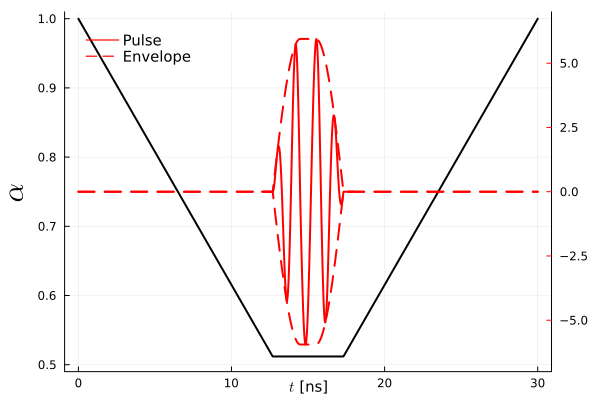

In [102]:
times = LinRange(0,30,2000)

tmp_p = copy(p_new)
tmp_p[6] = 0
# tmp_p[9] = 0
tmp_p[5] = 0

tmp_p2 = copy(p_new)
tmp_p2[6] = 0
# tmp_p2[9] = 0
tmp_p2[5] = pi/2

plt = plot(times,
     [alpha(p_new,t) for t in times],
     ylim=(0.49,1.01),
     linewidth=2,
     color="black",label=nothing,
     labelfontsize=20,ticklabelfontsize=20,
      ylabel=L"$\alpha$")

plot!(twinx(),
      [times[800:1200],times, times],
      [[pulse(p_new,t) for t in times[800:1200]],
       [sqrt(pulse(tmp_p,t)^2 + pulse(tmp_p2,t)^2) for t in times],
       [-sqrt(pulse(tmp_p,t)^2 + pulse(tmp_p2,t)^2) for t in times]],
      linewidth=2,
      color=[:red :red :red],
      ylim=(-7,7),
      ls = [:solid :dash :dash],
      label=["Pulse" "Envelope" ""],
      legend=:topleft,
      background_color_legend = nothing,
      foreground_color_legend = nothing,
      legendfontsize=10,
      labelfontsize=10,
      ticklabelfontsize=20,
      xlabel=L"$t$ [ns]",
      axiscolor=:red)



In [103]:
# savefig(plt,"RobustPhiSwapPulse.pdf")

"c:\\Users\\jv97\\github\\Quantum-Optimal-Control\\Production\\RobustPhiExt\\RobustPhiSwapPulse.pdf"

In [53]:
# params[end] #[Tᵣ, Tₐ, Tₚ, αmin, ϕ, f, A, Φ_ext, λ]
l1s[end], l2s[end]

(8.202861676565032e-5, 0.41431799613317744)

In [39]:
forward_prob = ODEProblem(f!, ψ0, (0.0, 30.0), p_new)
sol_f = solve(forward_prob, p=p_new, saveat=times, reltol=1e-8, abstol=1e-10)

retcode: Success
Interpolation: 1st order linear
t: 2000-element Vector{Float64}:
  0.0
  0.015007503751875937
  0.030015007503751873
  0.04502251125562781
  0.06003001500750375
  0.07503751875937968
  0.09004502251125562
  0.10505252626313157
  0.1200600300150075
  0.13506753376688344
  ⋮
 29.879939969984992
 29.89494747373687
 29.909954977488745
 29.92496248124062
 29.939969984992498
 29.954977488744372
 29.969984992496247
 29.984992496248125
 30.0
u: 2000-element Vector{Matrix{ComplexF64}}:
 [7.458437020914339e-10 + 1.9551902702793405e-19im 7.165380802393358e-10 - 4.465451818806265e-19im; 4.750172604670167e-9 - 2.4109872830822624e-9im 4.545922347254764e-9 + 2.4419982821121935e-9im; … ; 4.750172562092263e-9 + 2.410987280507997e-9im 4.545922304677384e-9 - 2.441998265656064e-9im; 7.458437153439597e-10 + 0.0im 7.16538051171195e-10 + 0.0im]
 [2.856083017361756e-10 + 6.88922765560864e-10im 2.8964258174424227e-10 + 6.553151205722371e-10im; 4.0457942523253685e-9 + 3.46445576280096e-9im -3.9

In [69]:
occs = zeros(Float64,length(sol_f.t),10,2)

for (i,t) in enumerate(sol_f.t)
    tmp_Es, tmp_ψs = eigs(KinPot12 + alpha(p_new,t) .* Potential3, nev=10, which=:SR)
    occs[i,:,:] = abs2.(tmp_ψs'*sol_f.u[i])
end

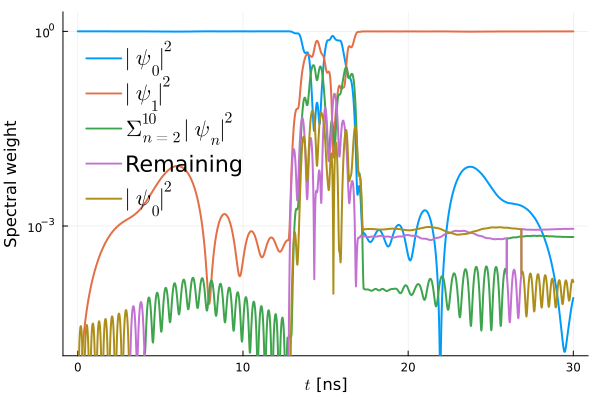

In [212]:
plt = plot(sol_f.t,
     [occs[:,1,1], 
     occs[:,2,1],
     occs[:,3,1],
     occs[:,4,1],
     occs[:,5,1]],
     # sum(occs[:,3:end,1],dims=2),
     # abs.(1 .- sum(occs[:,1:10,1],dims=2))],
     yaxis=:log10,
     ylim=(1e-5,2),
     linewidth=2,
     # yticks=[10^i for i=-5.:0],#(append!([i*10^j for i = 1:9 for j = -5.:-1],[1]),tmp)
     xlabel=L"$t$ [ns]",
     ylabel="Spectral weight",
     label=[L"$|\psi_0|^2$" L"|\psi_1|^2" L"$\Sigma_{n=2}^{10}|\psi_n|^2$" "Remaining"],
     legend=:topleft,
     background_color_legend = nothing,
     foreground_color_legend = nothing,
     legendfontsize=15,
     # xticks=0:2.5:12.5,
     # xlim=(10,20)
)

In [192]:
# savefig(plt,"RobustPhiSwapOccupation.pdf")

"c:\\Users\\jv97\\github\\Quantum-Optimal-Control\\Production\\RobustPhiExt\\RobustPhiSwapOccupation.pdf"

In [29]:
# writedlm("tmp_l1s6.txt",l1s)
# writedlm("tmp_l2s6.txt",l2s)
# writedlm("tmp_params6.txt",params)
# writedlm("tmp_calls6.txt",calls)

In [216]:
tmpEs, tmpψs = eigs(KinPot12 + 0.7 .* Potential3, nev=2, which=:SR)

tmpψs[:,1:2]'*chargecoupling*tmpψs[:,1:2]

2×2 Matrix{ComplexF64}:
 2.55351e-15+0.0im         0.0364575+0.292689im
   0.0364575-0.292689im  8.32667e-15-1.38778e-17im

In [121]:
function fidel(phi_ext,ps)
    Potential3 = get_Pot3(phi_ext)
    Es, ψs = eigs(KinPot12 + Potential3, nev=2, which=:SR, tol=0.0, maxiter=10000);

    function H!(du, u, p, t)
        du[:] = - im * (KinPot12 + alpha(p,t) .* Potential3 + pulse(p,t) .* chargecoupling) * u
    end

    forward_prob = ODEProblem(H!, ψs, (0.0, 30.0), ps)
    sol = solve(forward_prob, p=ps, save_everystep=false, reltol=1e-8, abstol=1e-10)

    UT = abs2.(ψs'*sol.u[end])
    return 0.5 * (2 - UT[1,2] - UT[2,1])
end    

fidel (generic function with 1 method)

In [107]:
fidel(0.97pi,p_new)

0.35863471285681436

In [105]:
fidel(0.95pi,p_new)

0.9988250953018711

In [111]:
phis = cat([0.97,0.98,0.99,0.993,0.99325,0.9935,0.99375,0.994],LinRange(0.994,0.99475,7)[2:end-1],LinRange(0.99475,0.995,7),dims=1)

phis = cat(phis, reverse(0.995 .+ (0.995 .- phis))[2:end],dims=1)
;
# plot(phis,phis,marker="o")

In [112]:
tmp_losses = []
for phi in phis
    push!(tmp_losses,fidel(phi*pi,p_new))
end

┌ Warning: Skipped marker arg ..
└ @ Plots C:\Users\jv97\.julia\packages\Plots\jqILG\src\args.jl:1203


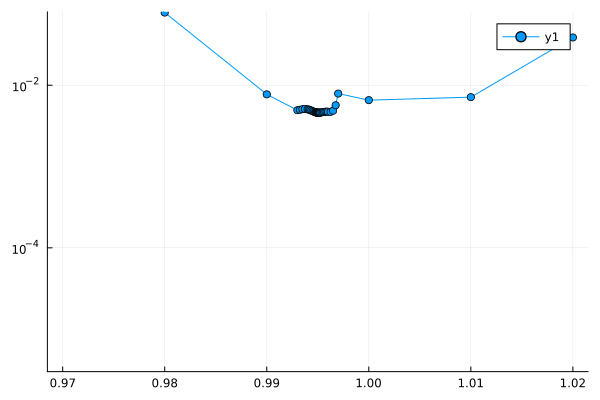

In [117]:
plot(phis,tmp_losses,yscale=:log10,marker=".",ylim=(3e-6,8e-2))

In [118]:
using ProgressMeter

In [122]:
tmp1_losses = []
# tmp2_losses = []
# tmp4_losses = []
tmp3_losses = []

p1 = [2, 10, 10, 0.7, 0.5418, 0.9763*2.482542369189332, 1.01556/0.2949509890806259, 0.995pi, 0.05289]
# p2 = copy(p_new)
# p4 = copy(readdlm("tmp_params5.txt")[end,:])
p3 = [1.8096066788458205,
10.151415509076779,
10.0,
0.7265360232227066,
2.819743639160394,
2.0448639414672374,
4.08982325027897,
3.1258846903218442,
0.03571156893603993]

# p3[2] = inv_limit_func(p3[2],0,15)
# p3[1] = inv_limit_func(p3[1],0,15 - p3[2])
# p3[4] = inv_limit_func(p3[4],0.5,1)

# p1[2] = inv_limit_func(p1[2],0,15)
# p1[1] = inv_limit_func(p1[1],0,15 - p1[2])
# p1[4] = inv_limit_func(p1[4],0.5,1)
# @showprogress for phi in [0.99pi, 0.991pi, 0.992pi, 0.993pi, 0.994pi,0.995pi,0.996pi, 0.997pi, 0.998pi, 0.999pi, pi]
@showprogress for phi in phis
    push!(tmp1_losses,fidel(phi*pi,p1))
    # push!(tmp2_losses,fidel(phi*pi,p2))
    # push!(tmp4_losses,fidel(phi*pi,p4))
    push!(tmp3_losses,fidel(phi*pi,p3))
end

Progress:   5%|███                                      |  ETA: 0:05:49

Progress:   8%|████                                     |  ETA: 0:05:41

Progress:  10%|█████                                    |  ETA: 0:05:26

Progress:  13%|██████                                   |  ETA: 0:05:14

Progress:  15%|███████                                  |  ETA: 0:05:06

Progress:  18%|████████                                 |  ETA: 0:04:57

Progress:  21%|█████████                                |  ETA: 0:04:48

Progress:  23%|██████████                               |  ETA: 0:04:41

Progress:  26%|███████████                              |  ETA: 0:04:35

Progress:  28%|████████████                             |  ETA: 0:04:27

Progress:  31%|█████████████                            |  ETA: 0:04:20

Progress:  33%|██████████████                           |  ETA: 0:04:11

Progress:  36%|███████████████                          |  ETA: 0:04:03

Progress:  38%|████████████████                         |  ETA: 0:03:52

Progress:  41%|█████████████████                        |  ETA: 0:03:41

Progress:  44%|██████████████████                       |  ETA: 0:03:29

Progress:  46%|███████████████████                      |  ETA: 0:03:18

Progress:  49%|████████████████████                     |  ETA: 0:03:07

Progress:  51%|██████████████████████                   |  ETA: 0:02:57

Progress:  54%|███████████████████████                  |  ETA: 0:02:47

Progress:  56%|████████████████████████                 |  ETA: 0:02:38

Progress:  59%|█████████████████████████                |  ETA: 0:02:29

Progress:  62%|██████████████████████████               |  ETA: 0:02:21

Progress:  64%|███████████████████████████              |  ETA: 0:02:12

Progress:  67%|████████████████████████████             |  ETA: 0:02:02

Progress:  69%|█████████████████████████████            |  ETA: 0:01:53

Progress:  72%|██████████████████████████████           |  ETA: 0:01:44

Progress:  74%|███████████████████████████████          |  ETA: 0:01:34

Progress:  77%|████████████████████████████████         |  ETA: 0:01:25

Progress:  79%|█████████████████████████████████        |  ETA: 0:01:16

Progress:  82%|██████████████████████████████████       |  ETA: 0:01:06

Progress:  85%|███████████████████████████████████      |  ETA: 0:00:57

Progress:  87%|████████████████████████████████████     |  ETA: 0:00:48

Progress:  90%|█████████████████████████████████████    |  ETA: 0:00:38

Progress:  92%|██████████████████████████████████████   |  ETA: 0:00:28

Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:19

Progress:  97%|████████████████████████████████████████ |  ETA: 0:00:09

Progress: 100%|█████████████████████████████████████████| Time: 0:06:06


In [181]:
"lol"*"ok"

"lolok"

┌ Warning: Skipped marker arg .
└ @ Plots C:\Users\jv97\.julia\packages\Plots\jqILG\src\args.jl:1203


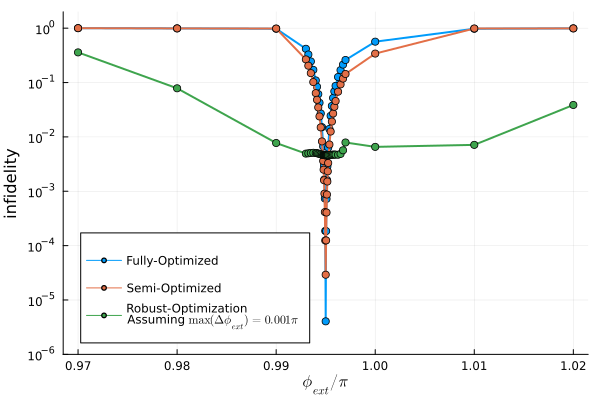

In [195]:
outputplot = plot(
    phis,
    [tmp3_losses,tmp1_losses,tmp_losses],
    yaxis=:log10,
    linewidth=2,
    legend=:bottomleft,
    marker="",
    label=["Fully-Optimized" "Semi-Optimized" "Robust-Optimization \n"*L"Assuming $\max(\Delta\phi_{ext}) = 0.001\pi$"],
    ylim=(1e-6,2),
    # xlim=(0.9929,0.99703),
    xlabel=L"$\phi_{ext} / \pi$",
    ylabel="infidelity"
    )

In [208]:
# phis[20], tmp_losses[19:21]
1 - 0.0045

0.9955

In [184]:
# savefig(outputplot,"RobustPhiInfidelities.pdf")

"c:\\Users\\jv97\\github\\Quantum-Optimal-Control\\Production\\RobustPhiExt\\RobustPhiInfidelities.pdf"

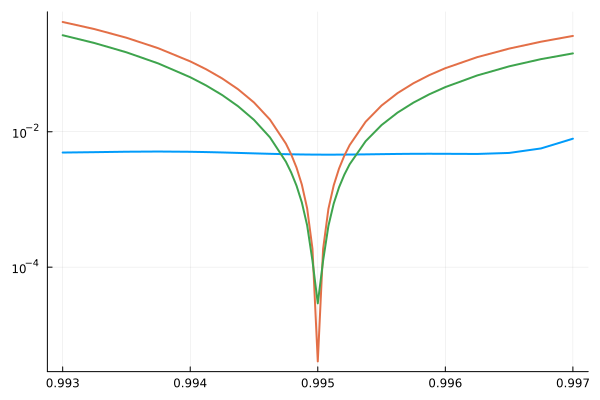

In [103]:
outputplot = plot(phis,[tmp_losses,tmp3_losses,tmp1_losses],yaxis=:log,linewidth=2,legend=nothing)

In [99]:
# savefig(outputplot,"BeautifulRobustness.pdf")

"c:\\Users\\jv97\\github\\Quantum-Optimal-Control\\Production\\BeautifulRobustness.pdf"

In [102]:
tmp1_losses./ones(11)

11-element Vector{Float64}:
 0.06382200265278937
 0.03991690415735
 0.021853458537448245
 0.00942874507165381
 0.002298652389022937
 2.9160349961532273e-5
 0.002149829165312145
 0.008195945371800739
 0.01773196293944468
 0.030350659263203628
 0.04564560806505197

┌ Warning: Skipped marker arg o.
└ @ Plots C:\Users\jv97\.julia\packages\Plots\jqILG\src\args.jl:1203


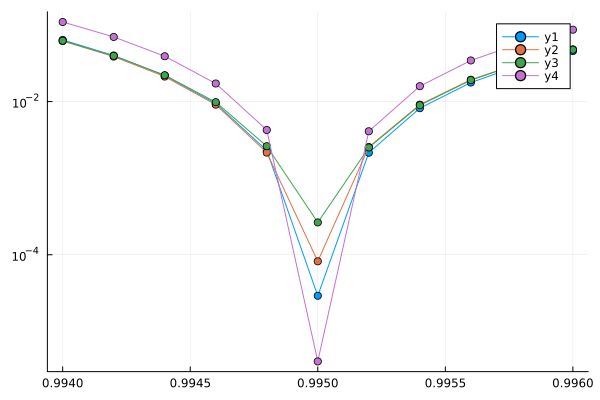

In [94]:
plot(LinRange(0.994,0.996,11),[tmp1_losses,tmp2_losses,tmp4_losses,tmp3_losses],yaxis=:log,marker="o")


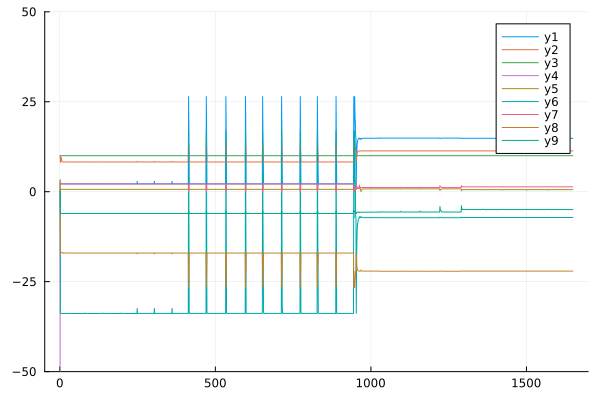

In [146]:
plot(transpose(cat(params...,dims=2)),ylim=(-50,50))


In [200]:
tmp = copy(p_new)
tmp[2] = limit_func(tmp[2],0,15)
tmp[1] = limit_func(tmp[1],0,15 - tmp[2])
tmp

9-element Vector{Float64}:
   1.5263572757019344
  11.472147443938331
  10.0
  -5.188952541845109
   0.6864151876375428
  -7.173438454226289
   0.7024191172650794
 -22.130712303163204
  -8.819182640524026

In [149]:
p_new

9-element Vector{Float64}:
   14.84292607534555
   11.341751839758764
   10.0
 -649.7661732132904
    0.5828557110984577
   -7.161153490188593
    1.3640811715268795
  -22.06506034791423
   -4.957612200539009